In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q
!pip install numpy scikit-image matplotlib -q

In [2]:
import numpy as np # for linear algebra
import pandas as pd # data preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf # deep learning
from tensorflow.keras import models, layers # working on layers
import matplotlib.pyplot as plt # data visualization

In [3]:
import os
from skimage import io, exposure, filters
from skimage.util import img_as_ubyte
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage import io

In [4]:
def normalize_image(image):
    """Normalize image pixel values."""
    return (image - np.mean(image)) / np.std(image)

def equalize_histogram(image):
    """Apply histogram equalization to enhance contrast."""
    return exposure.equalize_hist(image)

def apply_gaussian_filter(image, sigma=1):
    """Apply Gaussian filter to reduce noise."""
    return filters.gaussian(image, sigma=sigma)

def preprocess_image(image_path):
    """Load and preprocess an image."""
    try:
        # Load image using skimage
        image = io.imread(image_path)
        
        if image.ndim == 3: 
            image = tf.image.rgb_to_grayscale(image).numpy() 

        # Apply preprocessing steps
        image = normalize_image(image)
        image = equalize_histogram(image)
        image = apply_gaussian_filter(image)

        image = img_as_ubyte(image)
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)  
        elif image.ndim == 3 and image.shape[2] == 1:
            image = np.repeat(image, 3, axis=-1)

        if image.dtype != np.uint8:
            image = image.astype(np.uint8)  

        # Convert to PIL Image
        if image.ndim == 2: 
            return Image.fromarray(image, mode='L')
        elif image.ndim == 3: 
            return Image.fromarray(image, mode='RGB')
        else:
            raise ValueError("Unsupported image format")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [5]:
def process_images_in_folder(folder_path, output_folder):
    """Process all images in a specified folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        output_class_path = os.path.join(output_folder, class_folder)

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        for filename in os.listdir(class_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(class_path, filename)
                processed_image = preprocess_image(image_path) 
                
                if processed_image is not None:
                    output_path = os.path.join(output_class_path, filename)
                    processed_image.save(output_path) 
                else:
                    print(f"Skipping corrupted image: {filename}")

# Define paths
train_folder = r'C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor\Training'
test_folder = r'C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor\Testing'
processed_train_folder = r'C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor Pre Processed\processed_train'
processed_test_folder = r'C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor Pre Processed\processed_test'

# Process the images
process_images_in_folder(train_folder, processed_train_folder)
process_images_in_folder(test_folder, processed_test_folder)

c:\Users\wenur\anaconda3\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
c:\Users\wenur\anaconda3\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


Error processing image C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor\Training\glioma\Tr-gl_0121.jpg: not enough image data
Skipping corrupted image: Tr-gl_0121.jpg
Error processing image C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor\Training\glioma\Tr-gl_0122.jpg: not enough image data
Skipping corrupted image: Tr-gl_0122.jpg
Error processing image C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor\Training\glioma\Tr-gl_0123.jpg: not enough image data
Skipping corrupted image: Tr-gl_0123.jpg
Error processing image C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor\Training\glioma\Tr-gl_0124.jpg: not enough image data
Skipping corrupted image: Tr-gl_0124.jpg
Error processing image C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor\Training\glioma\Tr-gl_0125.jpg: not enough image data
Skipping corrupted image: Tr-gl_0125.jpg
Error processing image C:\Users\wenur\Documents\client_1\Brain Tumor\Brain Tumor\Training\glioma\Tr-gl_0126.jpg: not eno

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    processed_train_folder,
    target_size=(224, 224),
    color_mode='rgb',  
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    processed_test_folder,
    target_size=(224, 224),
    color_mode='rgb',  
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [7]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))  
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\wenur\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=epochs
)


Epoch 1/50


c:\Users\wenur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5475 - loss: 1.2220 - val_accuracy: 0.8039 - val_loss: 0.5423
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2:51 971ms/step - accuracy: 0.8125 - loss: 0.6138

c:\Users\wenur\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.6138 - val_accuracy: 1.0000 - val_loss: 0.2074
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.8550 - loss: 0.4319 - val_accuracy: 0.8414 - val_loss: 0.4063
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.2176 - val_accuracy: 0.9677 - val_loss: 0.1031
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8861 - loss: 0.3312 - val_accuracy: 0.8695 - val_loss: 0.3843
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.2841 - val_accuracy: 1.0000 - val_loss: 0.0662
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8988 - loss: 0.2681 - val_accuracy: 0.8961 - val_loss: 0.2864
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.1865 - val_accuracy: 1.0000 - val_loss: 0.0223
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9240 - loss: 0.2045 - val_accuracy: 0.8922 - 

In [9]:
model.save(r'C:\Users\wenur\Documents\client_1\Brain Tumor\preprocessed_CNN_epoch50.keras') 

In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.9496 - loss: 0.4000
Test accuracy: 0.97


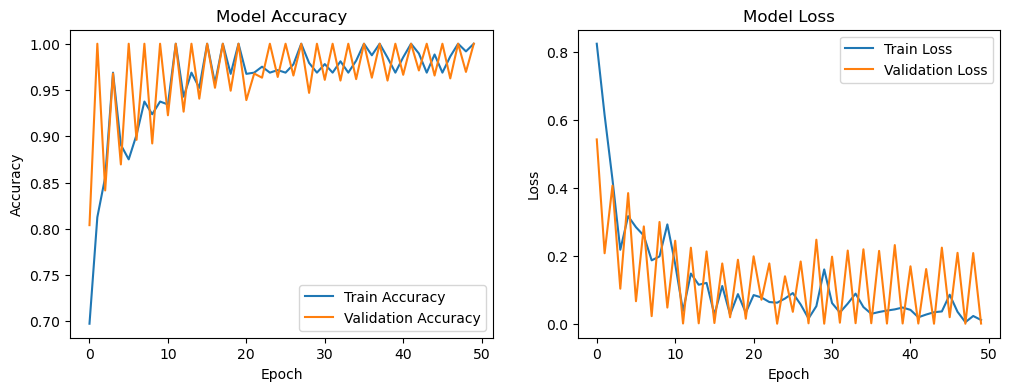

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,508,430 (127.82 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,954 (85.22 MB)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 276ms/step


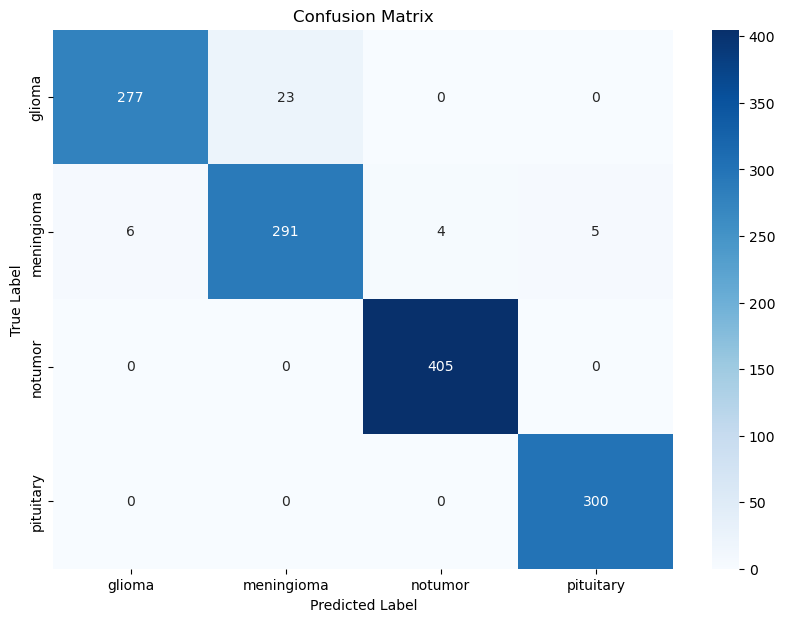

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = test_generator.classes

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1) 

cm = confusion_matrix(y_true, y_pred)

class_names = list(test_generator.class_indices.keys())

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)


In [14]:
# Get the final training accuracy
training_accuracy = history.history['accuracy'][-1] * 100

# Get the final validation accuracy
validation_accuracy = history.history['val_accuracy'][-1] * 100

print(f"Final Training Accuracy: {training_accuracy:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracy:.2f}%")


Final Training Accuracy: 100.00%
Final Validation Accuracy: 100.00%


In [15]:
class_accuracies = {}

# Calculate tumor-wise accuracy for each class
for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    false_negatives = cm[i, :].sum() - true_positives
    class_accuracy = true_positives / (true_positives + false_negatives) * 100
    class_accuracies[class_name] = class_accuracy

print("Tumor-Wise Accuracy:")
for class_name, accuracy in class_accuracies.items():
    print(f"{class_name}: {accuracy:.2f}%")

Tumor-Wise Accuracy:
glioma: 92.33%
meningioma: 95.10%
notumor: 100.00%
pituitary: 100.00%


In [16]:
from sklearn.metrics import classification_report
# Compute Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names))

report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.93      0.95      0.94       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311

              precision    recall  f1-score      support
glioma         0.978799  0.923333  0.950257   300.000000
meningioma     0.926752  0.950980  0.938710   306.000000
notumor        0.990220  1.000000  0.995086   405.000000
pituitary      0.983607  1.000000  0.991736   300.000000
accuracy       0.971014  0.971014  0.971014     0.971014
macro avg      0.969844  0.968578  0.968947  1311.000000
weighted avg   0.971279  0.971014  0.970902  1311.000000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


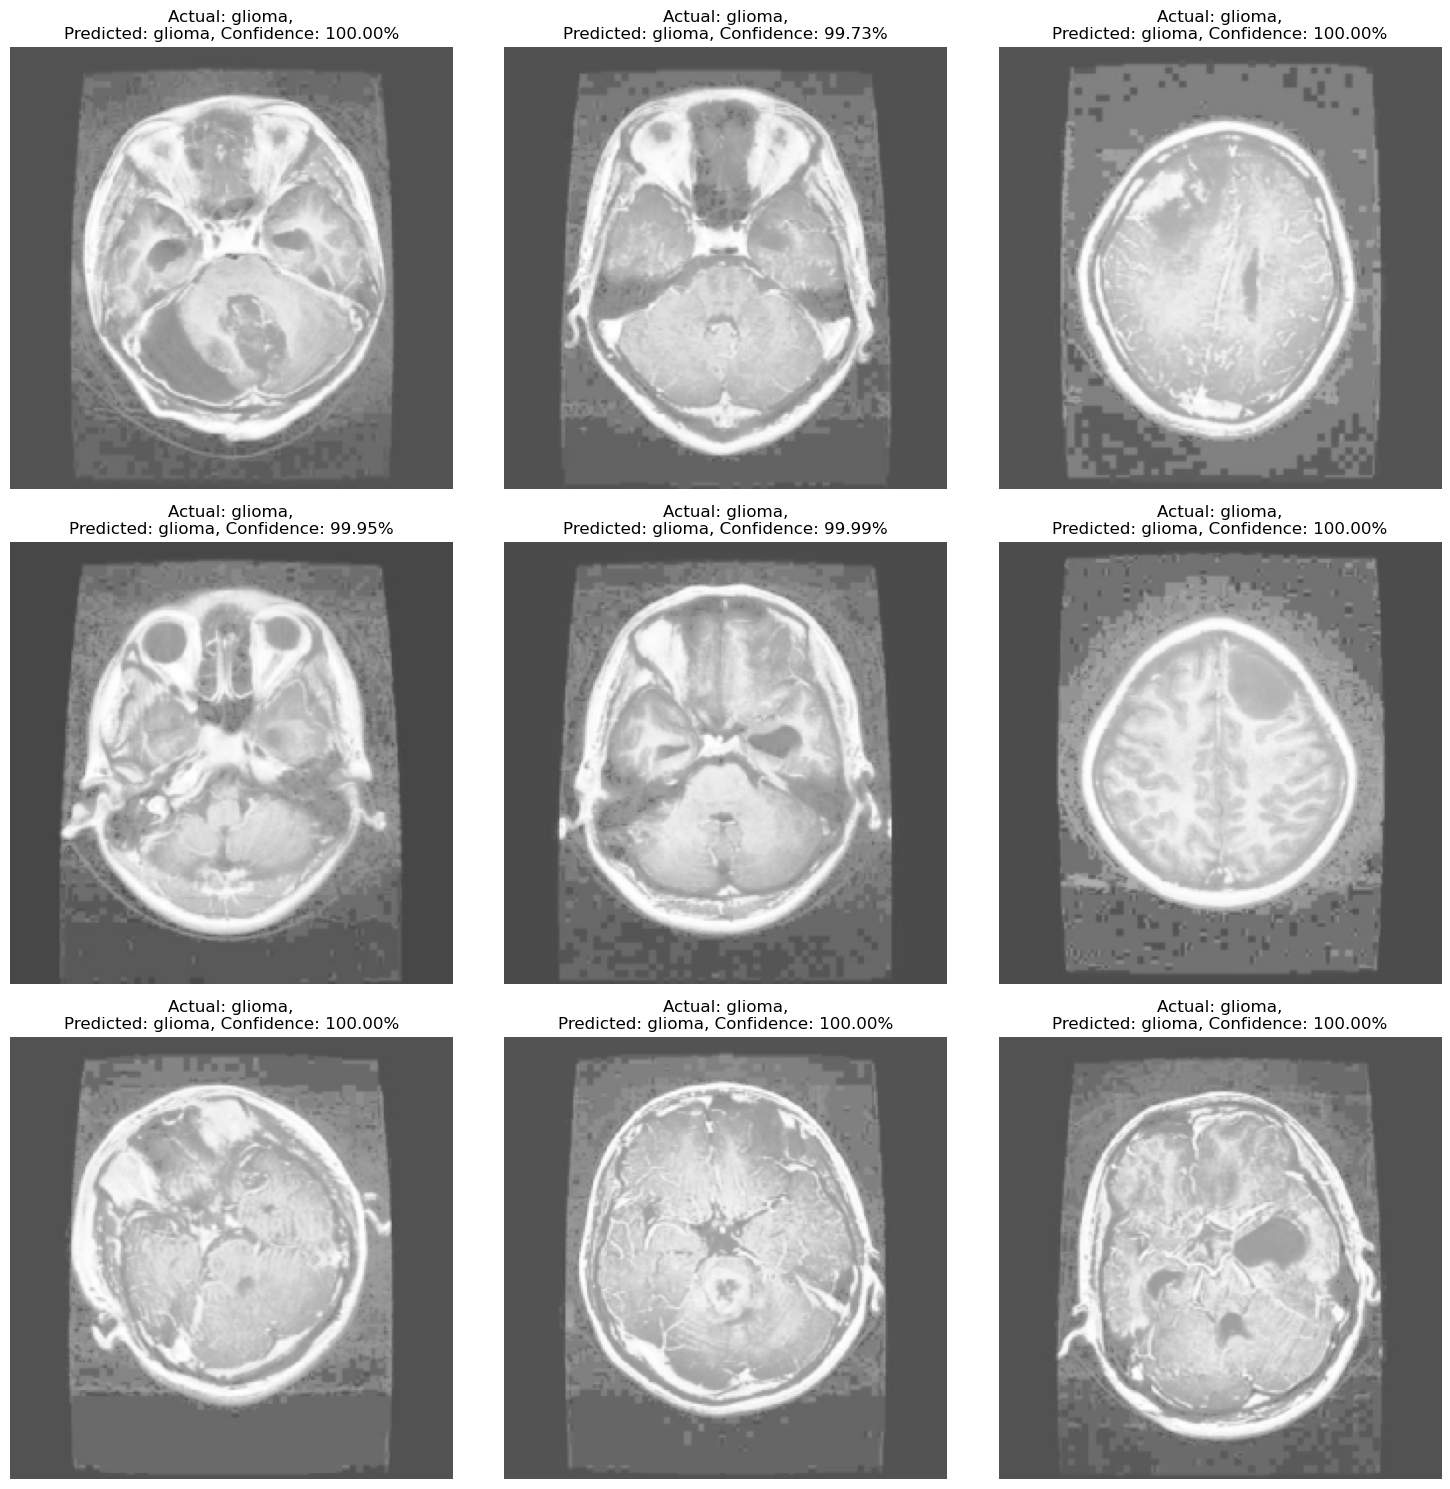

In [17]:
# Define the predict function
def predict(model, image):
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100
    return class_names[predicted_class], confidence

plt.figure(figsize=(15, 15))

for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        image = images[i] * 255.0
        image = np.clip(image, 0, 255).astype(np.uint8)
        
        plt.imshow(image)
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}, Confidence: {confidence:.2f}%")
        plt.axis("off")
    break 

plt.tight_layout()
plt.show()